# Importing the dataset

In [40]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
filepath = '/content/drive/MyDrive/dataset_proyecto3.csv'
df  = pd.read_csv(filepath)

In [43]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,simple_toxic
0,5f140a8f41763bad,"""== A barnstar for you! ==\r\n\r\n The Minor ...",0,0,0,0,0,0,0
1,c57b608d96f057f2,"""==Glenn Beck Hoax==\r\nThis topic should be d...",0,0,0,0,0,0,0
2,1d9867f0f60ba9bd,"""\r\n\r\n Date of establishment \r\n\r\nCharle...",0,0,0,0,0,0,0
3,17eb2a66bfce1023,==AfD nomination of Untitled Chilli Album== \r...,0,0,0,0,0,0,0
4,b8324615a1bcaf58,scum who look up to Che deserve the worst kind...,1,0,1,1,1,0,1


#Preprocess

In [44]:
from tensorflow.keras.layers import TextVectorization

In [45]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [46]:
MAX_FEATURES = 200000 # number of words in the vocab

In [47]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [79]:
vectorizer.adapt(X.values)

KeyboardInterrupt: ignored

In [49]:
vectorized_text = vectorizer(X.values)

In [50]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [51]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Create LTS

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [53]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='sigmoid'))

In [54]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 7)                 903       
                                                      

In [56]:
history = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2
978/978 [==============================] - 1618s 2s/step - loss: 0.1250 - val_loss: 0.0760
Epoch 2/2
978/978 [==============================] - 1663s 2s/step - loss: 0.0721 - val_loss: 0.0584


In [57]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

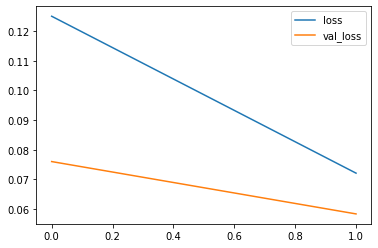

In [58]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

#Make Predictions

In [59]:
input_text = vectorizer(['You freaking suck! I am going to hit you.'])

In [60]:
res = model.predict(input_text)

In [61]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0, 1]])

#Tests

In [65]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [66]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [80]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [81]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8350785374641418, Recall:0.644444465637207, Accuracy:0.0


In [82]:
import tensorflow as tf

In [83]:
model.save('toxicity.h5')

In [84]:
model = tf.keras.models.load_model('toxicity.h5')

In [85]:
input_str = vectorizer('hello!')

In [86]:
res = model.predict(np.expand_dims(input_str,0))

In [87]:
res

array([[0.04285568, 0.00036326, 0.00995731, 0.00216275, 0.01005572,
        0.00390363, 0.0341    ]], dtype=float32)

In [88]:
input_str = vectorizer('fuck you!')

In [89]:
res = model.predict(np.expand_dims(input_str,0))

In [90]:
res

array([[0.9475925 , 0.26519245, 0.7953921 , 0.05914858, 0.6841166 ,
        0.28991345, 0.9632018 ]], dtype=float32)